In [1]:
import os
# http://www.cs.cornell.edu/people/pabo/movie-review-data/
# polarity dataset v2.0
# 1000 positive and 1000 negative movie reviews
TEXT_DATA_DIR = 'review_polarity/txt_sentoken/'

In [2]:
def prepare_texts_labels(TEXT_DATA_DIR):
    texts = []
    labels = []
    # iterate through directories to read each file
    for name in sorted(os.listdir(TEXT_DATA_DIR)):
        if not name.startswith('.'):
            path = os.path.join(TEXT_DATA_DIR, name)
            if os.path.isdir(path):
                for fname in sorted(os.listdir(path)):
                    fpath = os.path.join(path, fname)
                    with open(fpath, 'r') as myfile:
                        doc = myfile.read().replace('\n', '')
                        # store each review and label respectively
                        texts.append(doc)
                        if name == 'pos':
                            labels.append(+1)
                        else:
                            labels.append(0)
    return texts, labels

In [3]:
# Check the numbers of texts and labels
texts, labels = prepare_texts_labels(TEXT_DATA_DIR)
print(len(texts), len(labels))

2000 2000


In [4]:
# Check the average/maximum/minimum length of reviews in characters
total_avg = sum( map(len, texts) ) / len(texts)
print(total_avg)
print(len(max(texts, key=len)))
print(len(min(texts, key=len)))

3860.642
14898
90


In [5]:
import spacy
import numpy as np

In [6]:
# NEW in SpaCy V2: https://spacy.io/models/en#en_vectors_web_lg
nlp = spacy.load('en_vectors_web_lg')

In [7]:
# Tokenize reviews into a doc object
# Check the average/maximum/minimum length of reviews in tokens 
length_list = []

for i, review in enumerate(texts):
    doc = nlp.make_doc(review)
    length_list.append(len(doc))

print(np.mean(length_list), max(length_list), min(length_list))

778.0345 2810 18


In [8]:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
# Split data (and labels) into training and testing subsets
# Stratify the labels for both subsets (i.e., equal numbers of pos/neg reviews)
# Avoid imbalanced class distributions
X_train_data, X_test_data, y_train_label, y_test_label = train_test_split(texts, labels, test_size=0.1, random_state=5, stratify=labels)
print(len(X_train_data), len(y_train_label), y_train_label.count(+1), y_train_label.count(0))
print(len(X_test_data), len(y_test_label), y_test_label.count(+1), y_test_label.count(0))

1800 1800 900 900
200 200 100 100


In [9]:
# Keep only up to N first words in each review
# This is ad-hoc for this exercise. Other decisions could be made.
MAX_SEQUENCE_LENGTH = 777

In [10]:
# Functions customized based on https://spacy.io/docs/usage/deep-learning
# Using a simple concatenate representation in this exercise, not treating embedding as a whole 
def get_features(docs, MAX_SEQUENCE_LENGTH, nlp):
    Xs = np.empty((len(list(docs)), MAX_SEQUENCE_LENGTH*nlp.vocab.vectors_length), dtype=np.float64)
    for i, doc in enumerate(docs):
        doc = nlp.make_doc(doc)
        for j, token in enumerate(doc[:MAX_SEQUENCE_LENGTH]):
            if token.has_vector:
                vector = token.vector
            else:
                vector = np.zeros(nlp.vocab.vectors_length)
            for k in range(0, nlp.vocab.vectors_length):
                Xs[i, j*nlp.vocab.vectors_length + k] = vector[k]
    return Xs

In [11]:
# Get features for training data
X_train = get_features(X_train_data, MAX_SEQUENCE_LENGTH, nlp)
print(X_train.shape, X_train.dtype)

(1800, 233100) float64


In [12]:
# Get features for testing data
X_test = get_features(X_test_data, MAX_SEQUENCE_LENGTH, nlp)
print(X_test.shape, X_test.dtype)

(200, 233100) float64


In [13]:
# Converts class labels to numpy arrays
y_train = np.asarray(y_train_label, dtype='float64')
print(y_train.shape, y_train.dtype)
y_test = np.asarray(y_test_label, dtype='float64')
print(y_test.shape, y_test.dtype)

(1800,) float64
(200,) float64


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [15]:
def get_model():
    # Create a Sequential model with a linear stack of layers
    model = Sequential()
    # Add a hidden layer
    # operation in Dense layer: output = activation(dot(input, weight) + bias)
    model.add(Dense(units=1024, input_dim=MAX_SEQUENCE_LENGTH*nlp.vocab.vectors_length, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    # Add an output layer
    model.add(Dense(units=1, activation='sigmoid'))
    # Configure the learning process before model training
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [16]:
model = get_model()

In [17]:
# Train the model, iterating on the data in batches
history = model.fit(X_train, y_train, epochs=20, batch_size=50, validation_data=(X_test, y_test))

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 111s 62ms/step - loss: 1.4859 - acc: 0.5167 - val_loss: 0.7134 - val_acc: 0.5000
Epoch 2/20
1800/1800 [==============================] - 107s 60ms/step - loss: 0.5542 - acc: 0.7006 - val_loss: 0.6322 - val_acc: 0.6900
Epoch 3/20
1800/1800 [==============================] - 107s 60ms/step - loss: 0.0947 - acc: 0.9683 - val_loss: 1.7083 - val_acc: 0.5950
Epoch 4/20
1800/1800 [==============================] - 108s 60ms/step - loss: 0.0338 - acc: 0.9889 - val_loss: 1.3888 - val_acc: 0.6250
Epoch 5/20
1800/1800 [==============================] - 107s 60ms/step - loss: 0.0145 - acc: 0.9939 - val_loss: 1.4904 - val_acc: 0.6250
Epoch 6/20
1800/1800 [==============================] - 110s 61ms/step - loss: 0.0118 - acc: 0.9967 - val_loss: 1.5920 - val_acc: 0.6350
Epoch 7/20
1800/1800 [==============================] - 110s 61ms/step - loss: 8.0530e-04 - acc: 1.0000 - val_loss: 1.9384 - val_ac

In [18]:
# Print a summary of your model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              238695424 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
__________

In [19]:
# Evaluate the model against the 90% training data in terms of the loss value & metrics values
train_loss_and_metrics = model.evaluate(X_train, y_train, batch_size=128)
print(train_loss_and_metrics)
print("%s: %.2f%%" % (model.metrics_names[1], train_loss_and_metrics[1]*100))
# Results may vary, because data are split randomly in cell [5]

1800/1800 [==============================] - 13s 7ms/step
[3.4738464402532072e-07, 1.0]
acc: 100.00%


In [20]:
# Evaluate the model against the 10% validation data in terms of the loss value & metrics values
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
print(loss_and_metrics)
print("%s: %.2f%%" % (model.metrics_names[1], loss_and_metrics[1]*100))
# Results may vary, because data are split randomly in cell [5]

200/200 [==============================] - 1s 7ms/step
[3.1585782623291014, 0.65500000715255735]
acc: 65.50%


In [21]:
import matplotlib.pyplot as plt

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def visualize_model_training(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


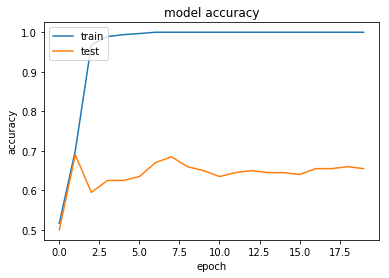

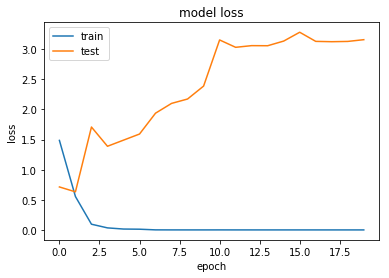

In [22]:
visualize_model_training(history)

In [23]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(X_true, y_true):

    probabilities = model.predict(X_true)
    
    y_pred = []
    for prob in probabilities:
        if prob[0] > 0.5:
            y_pred.append(+1)
        else:
            y_pred.append(0)

    print(confusion_matrix(y_true, y_pred))

In [24]:
get_confusion_matrix(X_test, y_test)

[[73 27]
 [42 58]]


In [ ]:
# Instantiate a Stratified 10-Folds cross-validator
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
# Avoid constructing folds with imbalanced class distributions
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=13)

In [ ]:
# Repeat the above process for 10 times to get average performance metrics
cvscores = []

X = np.asarray(texts)
Y = np.asarray(labels)

for train, test in kfold.split(X, Y):
    
    X_train = get_features(X[train].tolist(), MAX_SEQUENCE_LENGTH, nlp)    
    y_train = np.asarray(Y[train], dtype='float64')

    X_test = get_features(X[test].tolist(), MAX_SEQUENCE_LENGTH, nlp)    
    y_test = np.asarray(Y[test], dtype='float64')
    
    model = get_model()
    
    model.fit(X_train, y_train, epochs=5, batch_size=10, verbose=0)
    
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    get_confusion_matrix(X_test, y_test)
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [ ]:
# Delete session from keras backend to free sources
K.clear_session()